# LSTM Training with Walk-Forward Cross-Validation

This notebook implements walk-forward CV to find the optimal epoch count,
then trains a final model on 80% of the data (keeping 20% for EQCI calibration).

In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm

import sys
sys.path.append('../')
from models import LSTM_model
from dataset import EnergyPriceDataset, load_and_preprocess_energy_data

## Load Data with Date Info

In [2]:
df = load_and_preprocess_energy_data('../../data/energy_data.csv', keep_date=True)

feature_cols = [
    'Hour', 'day_nr', 'week_nr', 'year', 'month',
    'day_of_year_sin', 'day_of_year_cos',
    'wind_forecast_dah_mw', 'consumption_forecast_dah_mw',
    'temp_forecast_dah_celcius', 'temp_norm_celcius',
    'heating_demand_interaction', 'temp_deviation',
    'spot_lag1'
]
target_col = 'spot'

# 80/20 split - keep 20% for EQCI calibration
split_idx = int(len(df) * 0.8)
df_train_full = df.iloc[:split_idx].copy()
df_test = df.iloc[split_idx:].copy()  # held out for EQCI

print(f"Training data: {len(df_train_full)} samples")
print(f"Test data (EQCI calibration): {len(df_test)} samples")
print(f"Date range train: {df_train_full['date_time'].min()} to {df_train_full['date_time'].max()}")
print(f"Date range test: {df_test['date_time'].min()} to {df_test['date_time'].max()}")

Training data: 7026 samples
Test data (EQCI calibration): 1757 samples
Date range train: 2022-02-01 00:00:00+00:00 to 2022-11-20 17:00:00+00:00
Date range test: 2022-11-20 18:00:00+00:00 to 2023-02-01 22:00:00+00:00


## Create Walk-Forward CV Folds

Monthly folds within the 80% training data:
- Fold 1: Train [Feb-May] → Test [Jun]
- Fold 2: Train [Feb-Jun] → Test [Jul]
- etc.

In [3]:
# Create month-year period for fold creation
df_train_full['month_year'] = df_train_full['date_time'].dt.to_period('M')
unique_months = df_train_full['month_year'].unique()

print(f"Unique months in training data: {len(unique_months)}")
print(unique_months)

# Create folds - start with at least 4 months of training
min_train_months = 4
folds = []

for i in range(min_train_months, len(unique_months)):
    train_months = unique_months[:i]
    test_month = unique_months[i]
    
    train_mask = df_train_full['month_year'].isin(train_months)
    test_mask = df_train_full['month_year'] == test_month
    
    folds.append({
        'train_idx': df_train_full[train_mask].index,
        'test_idx': df_train_full[test_mask].index,
        'train_months': list(train_months),
        'test_month': test_month
    })

print(f"\nCreated {len(folds)} folds:")
for i, fold in enumerate(folds):
    print(f"  Fold {i+1}: Train {fold['train_months'][0]}-{fold['train_months'][-1]} ({len(fold['train_idx'])} samples) → Test {fold['test_month']} ({len(fold['test_idx'])} samples)")

Unique months in training data: 10
<PeriodArray>
['2022-02', '2022-03', '2022-04', '2022-05', '2022-06', '2022-07', '2022-08',
 '2022-09', '2022-10', '2022-11']
Length: 10, dtype: period[M]

Created 6 folds:
  Fold 1: Train 2022-02-2022-05 (2880 samples) → Test 2022-06 (720 samples)
  Fold 2: Train 2022-02-2022-06 (3600 samples) → Test 2022-07 (744 samples)
  Fold 3: Train 2022-02-2022-07 (4344 samples) → Test 2022-08 (744 samples)
  Fold 4: Train 2022-02-2022-08 (5088 samples) → Test 2022-09 (720 samples)
  Fold 5: Train 2022-02-2022-09 (5808 samples) → Test 2022-10 (744 samples)
  Fold 6: Train 2022-02-2022-10 (6552 samples) → Test 2022-11 (474 samples)


/var/folders/70/5ynsbx753cbgb1j_49jlwh7h0000gn/T/ipykernel_86246/2439249715.py:2: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df_train_full['month_year'] = df_train_full['date_time'].dt.to_period('M')


## Run Walk-Forward CV

In [4]:
sequence_length = 24
num_epochs = 150  # max epochs to try
batch_size = 32
learning_rate = 0.001

# Store results: (fold_idx, epoch, test_loss)
cv_results = []

for fold_idx, fold in enumerate(folds):
    print(f"\n{'='*50}")
    print(f"Fold {fold_idx + 1}/{len(folds)}: Train → {fold['test_month']}")
    print(f"{'='*50}")
    
    # Get fold data
    fold_train = df_train_full.loc[fold['train_idx']]
    fold_test = df_train_full.loc[fold['test_idx']]
    
    # Scale features (fit on fold's training data only)
    scaler_X = StandardScaler()
    scaler_y = StandardScaler()
    
    train_features = scaler_X.fit_transform(fold_train[feature_cols])
    train_targets = scaler_y.fit_transform(fold_train[[target_col]])
    
    test_features = scaler_X.transform(fold_test[feature_cols])
    test_targets = scaler_y.transform(fold_test[[target_col]])
    
    # Create datasets and loaders
    train_dataset = EnergyPriceDataset(train_features, train_targets, sequence_length)
    test_dataset = EnergyPriceDataset(test_features, test_targets, sequence_length)
    
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    
    # Initialize model
    model = LSTM_model(input_size=len(feature_cols))
    loss_func = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    
    # Train for num_epochs, recording test loss each epoch
    for epoch in range(num_epochs):
        # Training
        model.train()
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            predictions = model(X_batch)
            loss = loss_func(predictions, y_batch)
            loss.backward()
            optimizer.step()
        
        # Evaluate on fold's test set
        model.eval()
        test_loss = 0
        with torch.no_grad():
            for X_batch, y_batch in test_loader:
                pred = model(X_batch)
                test_loss += loss_func(pred, y_batch).item()
        test_loss /= len(test_loader)
        
        cv_results.append((fold_idx, epoch, test_loss))
        
        if (epoch + 1) % 25 == 0:
            print(f"  Epoch {epoch+1}: test_loss = {test_loss:.4f}")

print("\nCV training complete!")


Fold 1/6: Train → 2022-06
  Epoch 25: test_loss = 0.1072
  Epoch 50: test_loss = 0.1356
  Epoch 75: test_loss = 0.1939
  Epoch 100: test_loss = 0.1987
  Epoch 125: test_loss = 0.2975
  Epoch 150: test_loss = 0.3013

Fold 2/6: Train → 2022-07
  Epoch 25: test_loss = 0.1743
  Epoch 50: test_loss = 0.2808
  Epoch 75: test_loss = 0.2531
  Epoch 100: test_loss = 0.2257
  Epoch 125: test_loss = 0.2538
  Epoch 150: test_loss = 0.2325

Fold 3/6: Train → 2022-08
  Epoch 25: test_loss = 0.1641
  Epoch 50: test_loss = 0.2270
  Epoch 75: test_loss = 0.2401
  Epoch 100: test_loss = 0.2577
  Epoch 125: test_loss = 0.3375
  Epoch 150: test_loss = 0.3407

Fold 4/6: Train → 2022-09
  Epoch 25: test_loss = 0.1968
  Epoch 50: test_loss = 0.1730
  Epoch 75: test_loss = 0.2258
  Epoch 100: test_loss = 0.1848
  Epoch 125: test_loss = 0.3139
  Epoch 150: test_loss = 0.3999

Fold 5/6: Train → 2022-10
  Epoch 25: test_loss = 0.1335
  Epoch 50: test_loss = 0.1551
  Epoch 75: test_loss = 0.2186
  Epoch 100: tes

## Analyze CV Results

Optimal epoch: 11 (0-indexed: 10)
Average test loss at optimal: 0.1443 (± 0.0317)


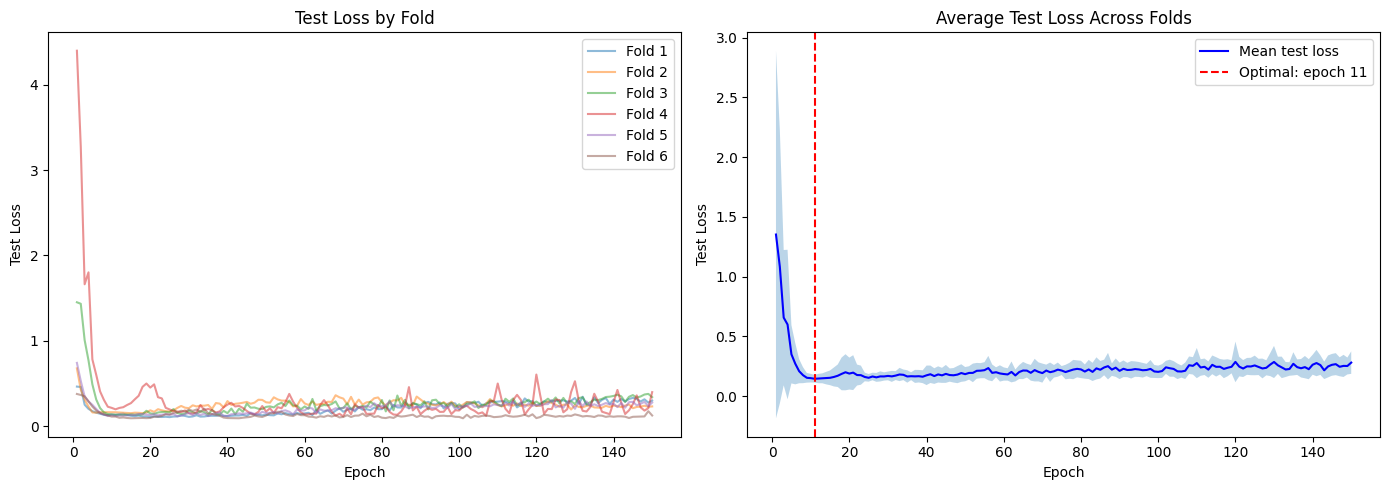

In [5]:
import matplotlib.pyplot as plt

# Convert to DataFrame for analysis
results_df = pd.DataFrame(cv_results, columns=['fold', 'epoch', 'test_loss'])

# Average test loss across folds for each epoch
avg_loss_by_epoch = results_df.groupby('epoch')['test_loss'].mean()
std_loss_by_epoch = results_df.groupby('epoch')['test_loss'].std()

# Find optimal epoch (cast to int for type safety)
optimal_epoch = int(avg_loss_by_epoch.idxmin())
optimal_loss = avg_loss_by_epoch[optimal_epoch]

print(f"Optimal epoch: {optimal_epoch + 1} (0-indexed: {optimal_epoch})")
print(f"Average test loss at optimal: {optimal_loss:.4f} (± {std_loss_by_epoch[optimal_epoch]:.4f})")

# Plot
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Left: All folds
for fold_idx in range(len(folds)):
    fold_data = results_df[results_df['fold'] == fold_idx]
    axes[0].plot(fold_data['epoch'] + 1, fold_data['test_loss'], alpha=0.5, label=f'Fold {fold_idx+1}')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Test Loss')
axes[0].set_title('Test Loss by Fold')
axes[0].legend()

# Right: Average with std band
epochs = np.array(avg_loss_by_epoch.index) + 1
mean_vals = np.array(avg_loss_by_epoch.values)
std_vals = np.array(std_loss_by_epoch.values)

axes[1].plot(epochs, mean_vals, 'b-', label='Mean test loss')
axes[1].fill_between(epochs, mean_vals - std_vals, mean_vals + std_vals, alpha=0.3)
axes[1].axvline(x=optimal_epoch + 1, color='r', linestyle='--', label=f'Optimal: epoch {optimal_epoch + 1}')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Test Loss')
axes[1].set_title('Average Test Loss Across Folds')
axes[1].legend()

plt.tight_layout()
plt.show()

## Train Final Model

Train on full 80% training data with optimal epoch count.
The 20% test set remains untouched for EQCI calibration.

In [8]:
print(f"Training final model for {optimal_epoch + 1} epochs on {len(df_train_full)} samples...")
print(f"(20% held out for EQCI: {len(df_test)} samples)")

# Prepare full training data (drop date columns for training)
scaler_X = StandardScaler()
scaler_y = StandardScaler()

train_features = scaler_X.fit_transform(df_train_full[feature_cols])
train_targets = scaler_y.fit_transform(df_train_full[[target_col]])

train_dataset = EnergyPriceDataset(train_features, train_targets, sequence_length)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)

# Initialize final model
final_model = LSTM_model(input_size=len(feature_cols))
loss_func = nn.MSELoss()
optimizer = torch.optim.Adam(final_model.parameters(), lr=learning_rate)

# Train for optimal number of epochs
for epoch in range(optimal_epoch + 2):
    final_model.train()
    total_loss = 0
    
    progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{optimal_epoch+1}")
    for X_batch, y_batch in progress_bar:
        optimizer.zero_grad()
        predictions = final_model(X_batch)
        loss = loss_func(predictions, y_batch)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    
    avg_loss = total_loss / len(train_loader)
    if (epoch + 1) % 10 == 0 or epoch == optimal_epoch:
        print(f"Epoch {epoch+1}: train_loss = {avg_loss:.4f}")

print("\nFinal model training complete!")

Training final model for 11 epochs on 7026 samples...
(20% held out for EQCI: 1757 samples)


Epoch 10/11: 100%|██████████| 219/219 [00:01<00:00, 150.54it/s]


Epoch 10: train_loss = 0.0748


Epoch 11/11: 100%|██████████| 219/219 [00:01<00:00, 150.38it/s]


Epoch 11: train_loss = 0.0708


Epoch 12/11: 100%|██████████| 219/219 [00:01<00:00, 146.63it/s]


Final model training complete!


## Save Model and Scalers

In [ ]:
import pickle

torch.save(final_model.state_dict(), 'lstm_model.pth')
pickle.dump((scaler_X, scaler_y), open('scalers.pkl', 'wb'))

print("Saved:")
print("  - lstm_model.pth")
print("  - scalers.pkl")
print(f"\nModel trained for {optimal_epoch + 1} epochs (determined by walk-forward CV)")

Saved:
  - lstm_model.pth
  - scalers.pkl

Model trained for 11 epochs (determined by walk-forward CV)
